In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      input_shape=input_shape)) 
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7472 - acc: 0.1051
Epoch 00001: val_loss improved from inf to 2.73355, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_1_conv_checkpoint/001-2.7335.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 2.7472 - acc: 0.1051 - val_loss: 2.7335 - val_acc: 0.1020
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5341 - acc: 0.2329
Epoch 00002: val_loss did not improve from 2.73355
36805/36805 [==============================] - 27s 734us/sample - loss: 2.5339 - acc: 0.2329 - val_loss: 2.8047 - val_acc: 0.1048
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.3182 - acc: 0.3169
Epoch 00003: val_loss did not improve from 2.73355
36805/36805 [==============================] - 27s 736us/sample - loss: 2.3183 - acc: 0.3169 - val_loss: 2.9142 

36800/36805 [============================>.] - ETA: 0s - loss: 0.6805 - acc: 0.8170
Epoch 00029: val_loss did not improve from 2.73355
36805/36805 [==============================] - 27s 729us/sample - loss: 0.6805 - acc: 0.8170 - val_loss: 6.3625 - val_acc: 0.1055
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6623 - acc: 0.8213
Epoch 00030: val_loss did not improve from 2.73355
36805/36805 [==============================] - 27s 722us/sample - loss: 0.6623 - acc: 0.8214 - val_loss: 6.4796 - val_acc: 0.1060
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6432 - acc: 0.8262
Epoch 00031: val_loss did not improve from 2.73355
36805/36805 [==============================] - 27s 722us/sample - loss: 0.6432 - acc: 0.8262 - val_loss: 6.5696 - val_acc: 0.1060
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6244 - acc: 0.8324
Epoch 00032: val_loss did not improve from 2.73355
36805/36805 [==================

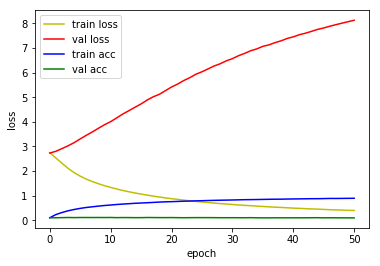

4815/4815 [==============================] - 2s 337us/sample - loss: 2.7252 - acc: 0.0953
Loss: 2.7251594565243984 Accuracy: 0.0953271

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3742 - acc: 0.2516
Epoch 00001: val_loss improved from inf to 2.17916, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_2_conv_checkpoint/001-2.1792.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.3742 - acc: 0.2516 - val_loss: 2.1792 - val_acc: 0.3249
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8823 - acc: 0.4165
Epoch 00002: val_loss improved from 2.17916 to 2.06719, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_2_conv_checkpoint/002-2.0672.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8824 - acc: 0.4165 - val_loss: 2.0672 - val_acc: 0.3534
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5938

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2006 - acc: 0.9387
Epoch 00030: val_loss did not improve from 2.06719
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2006 - acc: 0.9387 - val_loss: 4.3774 - val_acc: 0.3618
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1950 - acc: 0.9392
Epoch 00031: val_loss did not improve from 2.06719
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1950 - acc: 0.9392 - val_loss: 4.3502 - val_acc: 0.3536
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1893 - acc: 0.9409
Epoch 00032: val_loss did not improve from 2.06719
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.1894 - acc: 0.9409 - val_loss: 4.4700 - val_acc: 0.3645
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9477
Epoch 00033: val_loss did not improve from 2.06719
36805/36805 [===========

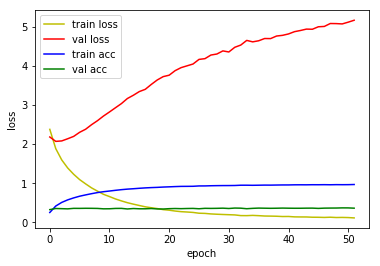

4815/4815 [==============================] - 2s 484us/sample - loss: 2.0949 - acc: 0.3421
Loss: 2.0949046964833546 Accuracy: 0.34205607

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0257 - acc: 0.3560
Epoch 00001: val_loss improved from inf to 1.66671, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_3_conv_checkpoint/001-1.6667.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.0256 - acc: 0.3560 - val_loss: 1.6667 - val_acc: 0.4752
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4626 - acc: 0.5434
Epoch 00002: val_loss improved from 1.66671 to 1.57152, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_3_conv_checkpoint/002-1.5715.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.4626 - acc: 0.5433 - val_loss: 1.5715 - val_acc: 0.5041
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.240

36800/36805 [============================>.] - ETA: 0s - loss: 0.1357 - acc: 0.9615
Epoch 00029: val_loss did not improve from 1.52505
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1357 - acc: 0.9615 - val_loss: 2.1497 - val_acc: 0.5926
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9631
Epoch 00030: val_loss did not improve from 1.52505
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1313 - acc: 0.9631 - val_loss: 2.1826 - val_acc: 0.5942
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1212 - acc: 0.9657
Epoch 00031: val_loss did not improve from 1.52505
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1212 - acc: 0.9657 - val_loss: 2.1693 - val_acc: 0.5924
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1191 - acc: 0.9679
Epoch 00032: val_loss did not improve from 1.52505
36805/36805 [========================

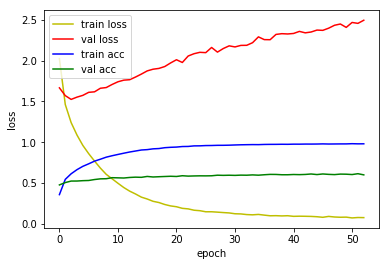

4815/4815 [==============================] - 3s 551us/sample - loss: 1.6062 - acc: 0.5001
Loss: 1.6061557545716394 Accuracy: 0.50010383

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8688 - acc: 0.3964
Epoch 00001: val_loss improved from inf to 1.47487, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_4_conv_checkpoint/001-1.4749.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.8687 - acc: 0.3964 - val_loss: 1.4749 - val_acc: 0.5465
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3836 - acc: 0.5684
Epoch 00002: val_loss improved from 1.47487 to 1.31403, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_4_conv_checkpoint/002-1.3140.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.3835 - acc: 0.5685 - val_loss: 1.3140 - val_acc: 0.6047
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.186

36800/36805 [============================>.] - ETA: 0s - loss: 0.1904 - acc: 0.9475
Epoch 00027: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1905 - acc: 0.9475 - val_loss: 1.2517 - val_acc: 0.6946
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1825 - acc: 0.9495
Epoch 00028: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1825 - acc: 0.9495 - val_loss: 1.2215 - val_acc: 0.7023
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1720 - acc: 0.9527
Epoch 00029: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1720 - acc: 0.9527 - val_loss: 1.2051 - val_acc: 0.7072
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1666 - acc: 0.9543
Epoch 00030: val_loss did not improve from 1.10338
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9780
Epoch 00057: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0812 - acc: 0.9780 - val_loss: 1.3761 - val_acc: 0.7223
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0832 - acc: 0.9791
Epoch 00058: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0832 - acc: 0.9791 - val_loss: 1.3985 - val_acc: 0.7179
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9802
Epoch 00059: val_loss did not improve from 1.10338
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0740 - acc: 0.9802 - val_loss: 1.4026 - val_acc: 0.7198
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0795 - acc: 0.9793
Epoch 00060: val_loss did not improve from 1.10338
36805/36805 [===========

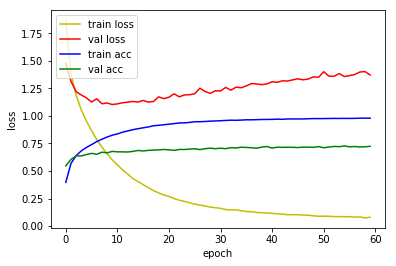

4815/4815 [==============================] - 3s 589us/sample - loss: 1.2182 - acc: 0.6370
Loss: 1.2181774709826318 Accuracy: 0.63696784

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8787 - acc: 0.3919
Epoch 00001: val_loss improved from inf to 1.48990, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_5_conv_checkpoint/001-1.4899.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.8786 - acc: 0.3919 - val_loss: 1.4899 - val_acc: 0.5332
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4276 - acc: 0.5520
Epoch 00002: val_loss improved from 1.48990 to 1.29452, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_5_conv_checkpoint/002-1.2945.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4275 - acc: 0.5520 - val_loss: 1.2945 - val_acc: 0.6070
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.235

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3389 - acc: 0.9083
Epoch 00025: val_loss did not improve from 0.80678
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3388 - acc: 0.9083 - val_loss: 0.8359 - val_acc: 0.7659
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2973 - acc: 0.9168
Epoch 00026: val_loss did not improve from 0.80678
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2973 - acc: 0.9168 - val_loss: 0.8213 - val_acc: 0.7699
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2897 - acc: 0.9191
Epoch 00027: val_loss did not improve from 0.80678
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2897 - acc: 0.9191 - val_loss: 0.8444 - val_acc: 0.7706
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2727 - acc: 0.9252
Epoch 00028: val_loss did not improve from 0.80678
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9713
Epoch 00055: val_loss did not improve from 0.80678
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1065 - acc: 0.9713 - val_loss: 0.9170 - val_acc: 0.7857
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0986 - acc: 0.9744
Epoch 00056: val_loss did not improve from 0.80678
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0986 - acc: 0.9744 - val_loss: 0.9114 - val_acc: 0.7894
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9738
Epoch 00057: val_loss did not improve from 0.80678
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0989 - acc: 0.9738 - val_loss: 0.9070 - val_acc: 0.7876
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9747
Epoch 00058: val_loss did not improve from 0.80678
36805/36805 [===========

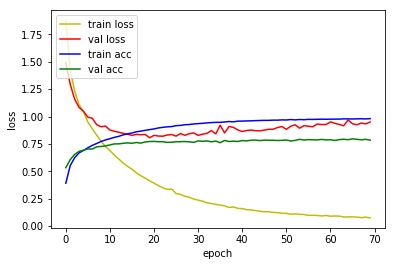

4815/4815 [==============================] - 3s 616us/sample - loss: 0.9044 - acc: 0.7423
Loss: 0.90441693653075 Accuracy: 0.74226373

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9244 - acc: 0.3708
Epoch 00001: val_loss improved from inf to 1.47005, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/001-1.4700.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.9243 - acc: 0.3708 - val_loss: 1.4700 - val_acc: 0.5383
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4793 - acc: 0.5311
Epoch 00002: val_loss improved from 1.47005 to 1.26668, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/002-1.2667.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4792 - acc: 0.5311 - val_loss: 1.2667 - val_acc: 0.6159
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2985 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4947 - acc: 0.8545
Epoch 00024: val_loss improved from 0.56423 to 0.55882, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/024-0.5588.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4946 - acc: 0.8545 - val_loss: 0.5588 - val_acc: 0.8421
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4841 - acc: 0.8582
Epoch 00025: val_loss improved from 0.55882 to 0.53920, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/025-0.5392.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4842 - acc: 0.8581 - val_loss: 0.5392 - val_acc: 0.8505
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4697 - acc: 0.8620
Epoch 00026: val_loss improved from 0.53920 to 0.53391, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/026-0.5339.hdf5
36805/36805 [=====

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2738 - acc: 0.9168
Epoch 00049: val_loss did not improve from 0.46888
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2737 - acc: 0.9168 - val_loss: 0.4774 - val_acc: 0.8689
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2680 - acc: 0.9199
Epoch 00050: val_loss did not improve from 0.46888
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2679 - acc: 0.9200 - val_loss: 0.4769 - val_acc: 0.8677
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2675 - acc: 0.9184
Epoch 00051: val_loss did not improve from 0.46888
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2675 - acc: 0.9184 - val_loss: 0.4938 - val_acc: 0.8735
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2639 - acc: 0.9208
Epoch 00052: val_loss did not improve from 0.46888
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1605 - acc: 0.9511
Epoch 00078: val_loss did not improve from 0.45860
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1605 - acc: 0.9511 - val_loss: 0.4677 - val_acc: 0.8838
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9531
Epoch 00079: val_loss did not improve from 0.45860
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1561 - acc: 0.9530 - val_loss: 0.4853 - val_acc: 0.8761
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1572 - acc: 0.9515
Epoch 00080: val_loss did not improve from 0.45860
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1572 - acc: 0.9515 - val_loss: 0.4626 - val_acc: 0.8845
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1517 - acc: 0.9531
Epoch 00081: val_loss did not improve from 0.45860
36805/36805 [========================

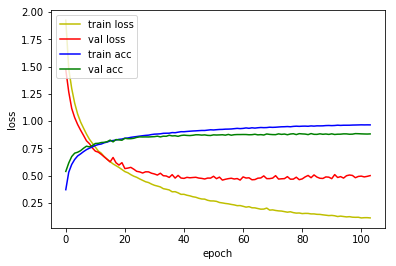

4815/4815 [==============================] - 3s 634us/sample - loss: 0.5394 - acc: 0.8455
Loss: 0.539416510850841 Accuracy: 0.8454829

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0034 - acc: 0.3442
Epoch 00001: val_loss improved from inf to 1.50943, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/001-1.5094.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 2.0034 - acc: 0.3442 - val_loss: 1.5094 - val_acc: 0.5297
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5377 - acc: 0.5048
Epoch 00002: val_loss improved from 1.50943 to 1.28353, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/002-1.2835.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.5377 - acc: 0.5048 - val_loss: 1.2835 - val_acc: 0.6152
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3268 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3765 - acc: 0.8918
Epoch 00023: val_loss did not improve from 0.35668
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.3766 - acc: 0.8918 - val_loss: 0.3639 - val_acc: 0.9008
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3641 - acc: 0.8938
Epoch 00024: val_loss improved from 0.35668 to 0.33453, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/024-0.3345.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.3641 - acc: 0.8938 - val_loss: 0.3345 - val_acc: 0.9101
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3528 - acc: 0.8989
Epoch 00025: val_loss improved from 0.33453 to 0.31716, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/025-0.3172.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.3527 - acc: 0.8989 - val_loss: 0.3172 - 

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2131 - acc: 0.9368
Epoch 00048: val_loss did not improve from 0.23968
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2131 - acc: 0.9368 - val_loss: 0.2598 - val_acc: 0.9287
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2172 - acc: 0.9342
Epoch 00049: val_loss did not improve from 0.23968
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2172 - acc: 0.9341 - val_loss: 0.2603 - val_acc: 0.9280
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2104 - acc: 0.9377
Epoch 00050: val_loss improved from 0.23968 to 0.23861, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/050-0.2386.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2104 - acc: 0.9377 - val_loss: 0.2386 - val_acc: 0.9315
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1345 - acc: 0.9579
Epoch 00076: val_loss did not improve from 0.23131
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1345 - acc: 0.9579 - val_loss: 0.2326 - val_acc: 0.9385
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1364 - acc: 0.9583
Epoch 00077: val_loss did not improve from 0.23131
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1364 - acc: 0.9583 - val_loss: 0.2333 - val_acc: 0.9378
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9573
Epoch 00078: val_loss did not improve from 0.23131
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1376 - acc: 0.9573 - val_loss: 0.2420 - val_acc: 0.9348
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9579
Epoch 00079: val_loss did not improve from 0.23131
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0948 - acc: 0.9692
Epoch 00105: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0948 - acc: 0.9692 - val_loss: 0.2469 - val_acc: 0.9404
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9739
Epoch 00106: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0896 - acc: 0.9739 - val_loss: 0.2433 - val_acc: 0.9383
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0908 - acc: 0.9728
Epoch 00107: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0908 - acc: 0.9728 - val_loss: 0.2433 - val_acc: 0.9425
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9725
Epoch 00108: val_loss did not improve from 0.23102
36805/36805 [=====================

Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0608 - acc: 0.9819
Epoch 00135: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0608 - acc: 0.9819 - val_loss: 0.2557 - val_acc: 0.9411
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9792
Epoch 00136: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0647 - acc: 0.9792 - val_loss: 0.2613 - val_acc: 0.9406
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9824
Epoch 00137: val_loss did not improve from 0.23102
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0606 - acc: 0.9824 - val_loss: 0.2485 - val_acc: 0.9422

1D_CNN_custom_tanh_DO_7_conv Model


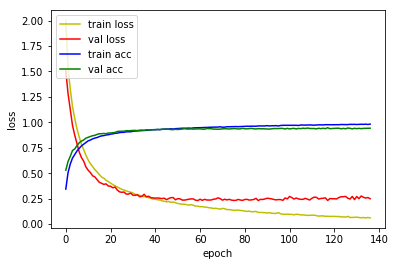

4815/4815 [==============================] - 3s 642us/sample - loss: 0.2755 - acc: 0.9192
Loss: 0.2754717957317396 Accuracy: 0.9192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9409 - acc: 0.3702
Epoch 00001: val_loss improved from inf to 1.40669, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/001-1.4067.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.9407 - acc: 0.3702 - val_loss: 1.4067 - val_acc: 0.5849
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3818 - acc: 0.5686
Epoch 00002: val_loss improved from 1.40669 to 1.06608, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/002-1.0661.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.3818 - acc: 0.5685 - val_loss: 1.0661 - val_acc: 0.6816
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1057

36800/36805 [============================>.] - ETA: 0s - loss: 0.2046 - acc: 0.9414
Epoch 00023: val_loss improved from 0.18480 to 0.18086, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/023-0.1809.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2046 - acc: 0.9414 - val_loss: 0.1809 - val_acc: 0.9490
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1996 - acc: 0.9429
Epoch 00024: val_loss improved from 0.18086 to 0.17383, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/024-0.1738.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1996 - acc: 0.9429 - val_loss: 0.1738 - val_acc: 0.9532
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1953 - acc: 0.9435
Epoch 00025: val_loss improved from 0.17383 to 0.17339, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/025-0.1734.hdf5
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9709
Epoch 00050: val_loss did not improve from 0.14365
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0974 - acc: 0.9709 - val_loss: 0.1490 - val_acc: 0.9595
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9723
Epoch 00051: val_loss did not improve from 0.14365
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0922 - acc: 0.9723 - val_loss: 0.1571 - val_acc: 0.9574
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0896 - acc: 0.9728
Epoch 00052: val_loss did not improve from 0.14365
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0895 - acc: 0.9728 - val_loss: 0.1531 - val_acc: 0.9571
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9735
Epoch 00053: val_loss did not improve from 0.14365
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9875
Epoch 00080: val_loss did not improve from 0.13754
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0442 - acc: 0.9875 - val_loss: 0.1673 - val_acc: 0.9541
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9870
Epoch 00081: val_loss did not improve from 0.13754
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0449 - acc: 0.9870 - val_loss: 0.1555 - val_acc: 0.9597
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9868
Epoch 00082: val_loss did not improve from 0.13754
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0422 - acc: 0.9868 - val_loss: 0.1486 - val_acc: 0.9599
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9880
Epoch 00083: val_loss did not improve from 0.13754
36805/36805 [===========

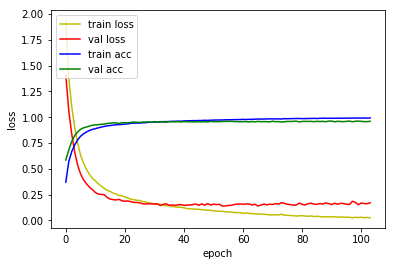

4815/4815 [==============================] - 3s 678us/sample - loss: 0.1873 - acc: 0.9433
Loss: 0.18725951010069247 Accuracy: 0.94330215

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5903 - acc: 0.4965
Epoch 00001: val_loss improved from inf to 0.93548, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/001-0.9355.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.5903 - acc: 0.4965 - val_loss: 0.9355 - val_acc: 0.7263
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8652 - acc: 0.7410
Epoch 00002: val_loss improved from 0.93548 to 0.56262, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/002-0.5626.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8651 - acc: 0.7410 - val_loss: 0.5626 - val_acc: 0.8430
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.61

36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9736
Epoch 00024: val_loss did not improve from 0.12880
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0894 - acc: 0.9736 - val_loss: 0.1301 - val_acc: 0.9597
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9752
Epoch 00025: val_loss improved from 0.12880 to 0.12550, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/025-0.1255.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0842 - acc: 0.9752 - val_loss: 0.1255 - val_acc: 0.9616
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0819 - acc: 0.9755
Epoch 00026: val_loss did not improve from 0.12550
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0819 - acc: 0.9755 - val_loss: 0.1320 - val_acc: 0.9588
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9952
Epoch 00053: val_loss did not improve from 0.12150
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0205 - acc: 0.9952 - val_loss: 0.1423 - val_acc: 0.9625
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9945
Epoch 00054: val_loss did not improve from 0.12150
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0212 - acc: 0.9945 - val_loss: 0.1504 - val_acc: 0.9604
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9944
Epoch 00055: val_loss did not improve from 0.12150
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0207 - acc: 0.9944 - val_loss: 0.1436 - val_acc: 0.9632
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9957
Epoch 00056: val_loss did not improve from 0.12150
36805/36805 [===========

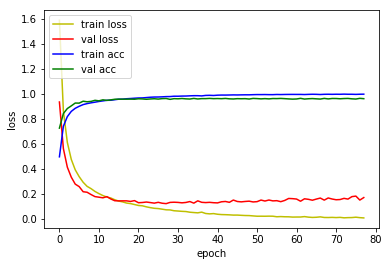

4815/4815 [==============================] - 3s 668us/sample - loss: 0.1681 - acc: 0.9477
Loss: 0.16811249554776206 Accuracy: 0.94766355



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_tanh_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 374us/sample - loss: 2.7252 - acc: 0.0953
Loss

4815/4815 [==============================] - 3s 703us/sample - loss: 0.9044 - acc: 0.7423
Loss: 0.90441693653075 Accuracy: 0.74226373

1D_CNN_custom_tanh_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 53

4815/4815 [==============================] - 4s 730us/sample - loss: 0.1873 - acc: 0.9433
Loss: 0.18725951010069247 Accuracy: 0.94330215

1D_CNN_custom_tanh_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None,

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 417us/sample - loss: 8.1461 - acc: 0.0987
Loss

4815/4815 [==============================] - 4s 758us/sample - loss: 1.1235 - acc: 0.7433
Loss: 1.1234925141339485 Accuracy: 0.74330217

1D_CNN_custom_tanh_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 

4815/4815 [==============================] - 4s 787us/sample - loss: 0.2142 - acc: 0.9410
Loss: 0.21423647905838206 Accuracy: 0.9410176

1D_CNN_custom_tanh_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 